# Analysis and Comparison Samples

This Notebook will lead you through exercises to help you compare your results to larger samples of exoplanets, and to place them in the context of the 'bigger picture'. In this notebook, you will:

$\bullet$ Analyse large sets of data and learn to quantify whether any given set of parameters are correlated

$\bullet$ Learn how to quantify whether different samples are consistent with having the same underlying distribution of some given property, and thus address the question of selection effects

$\bullet$ Learn to make statistical comparisons between the properties of your source and other exoplanet populations

## Parameter distributions and correlations
Now that you have measured parameters for your target, a next obvious question to ask is how this compares to other exoplanets, and what have we learned from the single object that you have looked into? Any such comparison should

$\bullet$ be carried out using statistical tools to be able to quantify the relation between your object and other samples of exoplanets

$\bullet$ consider the effects of error bars, and incorporate these uncertainties in any statistical comparison carried out

$\bullet$ investigate the effects of selection effects and understand the limitations of your data in addressing a given science question

Let's first see how we can carry out such statistical analysis on a completely different sample of astronomical data.

## The Mass- Metallicity relation
There is a well known, positive relation between the stellar mass of a galaxy, M$_\star$, and the gas-phase oxygen abundance (mass of oxygen, O, relative to mass of hydrogen, H), or 'metallicity', which is commonly given in units of $12+\log(\rm{O/H})$. This is referred to as the *mass-metallicity relation*, or MZR.

Below we will use a large sample of galaxies with measured stellar mass and metallicity to explore how the relation between M$_\star$ and $12+\log(\rm{O/H})$ and its significance are assessed and quantified.

In [5]:
# Import necessary modules to read in sample parameters from a file... 
import numpy as np
import seaborn as sns
from astropy.io import fits
from CompSample import read_exopars, linfit, Zrecal, conflevels, density_scatter
#
# ..and to plot distributions
import pylab
import matplotlib.cm as cm

In [4]:
# The file 'MZR.fits' contains measured star formation rates (SFR),
# stellar masses, and metallicities for a sample of over 100,000 
# nearby, star-forming galaxies 
#
# Let's see how the galaxy stellar mass and metallicity are related
# First we read in the data stored in the file 'MZR.fits'
galaxy_props = fits.open('Data/MZR.fits')

# Then we extract the logarithmic stellar mass and the metallicity, Z,
# which for galaxies is commonly measured in terms of the oxygen abundance 12+log(O/H)
logMstar = galaxy_props[''].data['MSTAR']
Z = galaxy_props[''].data['Z']

# The sample of galaxies lie at a range of redshifts
# in the range z=0.005-0.25

# Let's only consider those galaxies at redshifts 0.1<z<0.2
# and plot Z against logMstar

# let's read in the redshift information..
redshift = galaxy_props[''].data['RS']

#.. and select the redshift range of interest
zrange = (redshift>0.1) * (redshift<0.2)
logMstar_loz=logMstar[zrange][:]
Z_loz=Z[zrange][:]

# Now let's plot the data
pylab.xlabel(r'Log (M$_\star$/M$_\odot$)',fontsize=18)
pylab.ylabel(r'12+log(O/H)',fontsize=18)
dencol_loz=density_scatter(logMstar_loz, Z_loz, bins = [300,300])
pylab.scatter(logMstar_loz, Z_loz, c=dencol_loz,cmap=cm.plasma,label='Galaxy population at 0.1<z<0.2')
pylab.errorbar([8.8],[8.2],xerr=[0.1],yerr=[0.1],c='k',label='Typical error') #typical error
pylab.legend(loc=4)

FileNotFoundError: [Errno 2] No such file or directory: 'Data/MZR.fits'

#### The above plot shows the known positive correlation between galaxy mass and oxygen abundance.
Let's investigate this apparent correlation in greater detail

## Fitting Correlations 

In [4]:
# Let's try a linear fit to the data
slope,slope_err,m,m_err = linfit(logMstar_loz,Z_loz)

print('\033[1m' + "Linear fit has best-fit parameters:\n\tgradient = %.3f +/- %.3f\n\tintercept = %.3f +/- %.3f\n" % (slope,slope_err,m,m_err) + '\033[0m')

Linear fit has best-fit parameters:
	gradient = 0.224 +/- 0.002
	intercept = 6.668 +/- 0.021



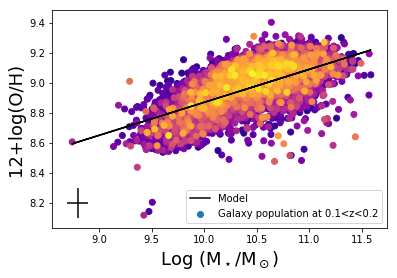

In [5]:
# Let's see how the fit looks

# Define the function for a linear relation
linear = lambda x, intercept, grad: intercept + (x*grad)
#
# Plot data points along with best-fit power-law fit
pylab.xlabel(r'Log (M$_\star$/M$_\odot$)',fontsize=18)
pylab.ylabel(r'12+log(O/H)',fontsize=18)
pylab.scatter(logMstar_loz, Z_loz, c=dencol_loz,cmap=cm.plasma,label='Galaxy population at 0.1<z<0.2')
pylab.plot(logMstar_loz, linear(logMstar_loz,6.67,0.22),c='k',zorder=2,label='Model')
pylab.errorbar([8.8],[8.2],xerr=[0.1],yerr=[0.1],c='k') #typical error
pylab.legend(loc=4)

#### Although the linear fit looks reasonble, there is clear scatter in the relation. We need to be able to quantify the significance of the apparent correlation

## Testing the significance of a correlation; the rank correlation

We have now explored how we might try and quantify the relation between two variables; in the case above we found that galaxy stellar mass and metallicity are positively correlated. However, it is also important to be able to quantify how significant this relation is, rather than just eye-balling it.

To test this, we can use rank correlations to test the signifance of the relation between two parameters. 

### Non-parametric correlation tests
A rank correlation coefficient measures the degree of similarity between two rankings, and can be used to assess the significance of the relation between them without assuming some parameterised relation.

Two popular rank correlation statistics are the **Spearman's $\rho$** and **Kendall's $\tau$ rank tests**. An increasing rank correlation coefficient ($\rho$ or $\tau$) implies increasing agreement between rankings, where coefficients lie inside the interval [-1,1] where:

1: the agreement between the two rankings is perfect

0: the rankings are completely independent

-1: the disagreement between the two rankings is perfect, so they are inversely related. 

In addition to providing a rank, a 'p-value' is also important, which provides the probability of finding a similar rank value given the null hypothesis that the two sets of parameters are uncorrelated. Therefore, low values of the p-value imply that the correlation rank is significant. We will discuss this in more detail below.

### Parametric correlation tests
Parametric correlation tests asses the linear relations between two parameters. A commonly used parametric correlation test is the **Pearson's test**, which measures the linear correlation between two variables X and Y.

Similar to the Spearman's rank correlation coefficient, the Pearson's correlation coefficient, $r$, can have a value between -1 and 1, where -1 is total negative linear correlation, 0 is no linear correlation, and 1 is total positive linear correlation.

In [6]:
# Let's use the Spearman's rank test to assess
# the significance of our correlation

# First we import the necessary module
from scipy.stats import spearmanr

# Now let's calculate the spearman rank correficient
rank,sp_pvalue = spearmanr(logMstar_loz,Z_loz)

print('\033[1m' + "Z and stellar mass have a Spearman's rank %.2f and p-value of %.2e" % (rank,sp_pvalue) + '\033[0m')

print('\n(I.e. there is %.1f%% probability that the Speaman rank is >%.2f \ngiven the null hypothesis)' % (sp_pvalue,rank))

Z and stellar mass have a Spearman's rank 0.62 and p-value of 0.00e+00

(I.e. there is 0.0% probability that the Speaman rank is >0.62 
given the null hypothesis)


### Interpretation of rank value and the p-value
In statistics, the null hypothesis is the hypothesis that there is nothing new or special between two samples, such as there is no association among groups, or no relationship between two measured phenomena. In the case of correlation tests, the null hypothesis is thus the premis that the two samples are not correlated. The p-value provides the probability of getting the measured correlation coefficent, given the null hypothesis.

In our test above, the rank value was $\rho=0.62$ with a p-value=0.00. This tells us that there is a strong positive correlation (although not perfect) between stellar mass and metallicity, and this correlation is highly significant. I.e. the probability that the data would have a rank coefficient $\rho=0.62$ or larger if the two parameters were not correlated (i.e. the null hypothesis) is 0%. Another way of thinking about this is that there is 0% probability that this dataset could have a rank correlation coefficient of $\rho=0.62$ by chance.

### When to reject the null hypothesis
Let's consider two data sets corresponding to completely independent and thus uncorrelated parameters. If we took multiple draws from these data sets and performed a rank correlation test for each draw, we would measure a distribution of rank values, a some small fraction of which may indicate that the data are correlated. The distribution of these rank values enable us to determine what the probability is of obtainining any given rank value when the data are not correlated (i.e. the null hypothesis). For example, let's assume we re-ran the rank correlation test and obtain a rank value $\rho_1$. If our previously derived distribution of rank coefficients show that 3% have a value $\rho>\rho_1$, our measured rank value of $\rho_1$ then has an associated p-value of 0.03.

The distribution of rank values given the null hypothesis will depend on the number of data points used in the correlation tests. The larger the number of data points, the lower the probability of producing a correlation by chance, or conversely, of removoing any signs of a correlation, when in fact there is one. It is fairly common to use 5% as the threshold probability below which we 'reject' the null hypothesis. I.e. if we measure some rank value with a p-value<0.05, it is then standard to reject the null hypothesis that the two parameters compared are *not* correlated.

This of course still means that there is up to 5% chance that you'll get the correlation coefficient that you measured, even when the parameters are not correlated. For example, see 'Spurious Correlations' (www.tylervigen.com/spurious-correlations ).

In [7]:
# Now let's see how the Pearon's correlation test compares
from scipy.stats import pearsonr
PCC,PCC_pvalue = pearsonr(logMstar_loz,Z_loz)

print('\033[1m' + "Z and stellar mass have a Pearson's correlation coefficient %.2f \nand p-value of %.2e" % (PCC,PCC_pvalue) + '\033[0m')

print('\n(I.e. there is %.1f%% probability that the Speaman rank is >%.2f \ngiven the null hypothesis)' % (PCC_pvalue,PCC))

Z and stellar mass have a Pearson's correlation coefficient 0.67 
and p-value of 0.00e+00

(I.e. there is 0.0% probability that the Speaman rank is >0.67 
given the null hypothesis)


That's reassuring that both tests provide a similar result, which also suggests that $12+ \log(\rm{O/H})$ and $\log(\rm{M}_\star/\rm{M}_\odot)$ are linearly related 

### What happens if we randomly select a subsample from the above parent distribution?

In [9]:
import numpy.random as rd

list = np.arange(len(logMstar_loz))
indices=rd.choice(list,15)

PCC,PCC_pvalue = pearsonr(logMstar_loz[indices],Z_loz[indices])

print('\033[1m' + "Z and stellar mass have a Pearson's correlation coefficient %.2f \nand p-value of %.2e" % (PCC,PCC_pvalue) + '\033[0m')

print('\n(I.e. there is %.1f%% probability that the Speaman rank is >%.2f \ngiven the null hypothesis)' % (PCC_pvalue*100.,PCC))

Z and stellar mass have a Pearson's correlation coefficient 0.22 
and p-value of 4.37e-01

(I.e. there is 43.7% probability that the Speaman rank is >0.22 
given the null hypothesis)


Try running the above calculation several times. What happens to the correlation coefficient and the null hypothesis probability?

## Bonus excercises

#### Mass-metallicity relation at 0.2<z<0.3

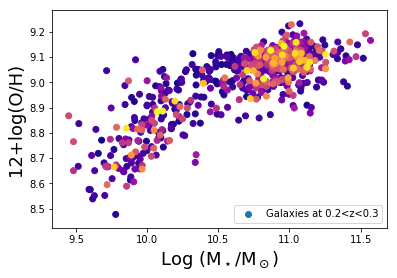

In [10]:
# Let's now consider the mass-metallicity relation
# for galaxy samples in the redshift bin 0.2<z<0.3

# Set redshift range of interest
zrange2 = (redshift>0.2) * (redshift<0.3)
logMstar_midz=logMstar[zrange2][:]
Z_midz=Z[zrange2][:]

# Plot data
pylab.xlabel(r'Log (M$_\star$/M$_\odot$)',fontsize=18)
pylab.ylabel(r'12+log(O/H)',fontsize=18)
dencol_midz=density_scatter(logMstar_midz, Z_midz, bins = [30,30])
pylab.scatter(logMstar_midz,Z_midz,c=dencol_midz,cmap=cm.plasma,label='Galaxies at 0.2<z<0.3')
pylab.legend(loc=4)

### Your turn
What is the best-fit relation and corresponding significance between metallicity and stellar mass for the sample of galaxies at 0.2<z<0.3, and how does this compare to galaxies at lower redshift?

What can you therefore say about how the mass-metallicity relation at 0.1<z<0.2 compares to that at 0.2<z<0.3

## Residuals in our fit
A very useful way of checking the validy of a model is be looking at the residuals, which corresponds to the ratio of the data over the model. A perfect model would give residuals of 1.

<ErrorbarContainer object of 3 artists>

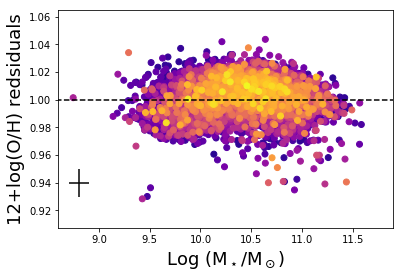

In [11]:
# Let's check the residuals on the modelled metallicity
pylab.xlabel(r'Log (M$_\star$/M$_\odot$)',fontsize=18)
pylab.ylabel(r'12+log(O/H) redsiduals',fontsize=18)
pylab.xlim(8.6,11.9)
pylab.scatter(logMstar_loz, Z_loz/linear(logMstar_loz,6.67,0.22), c=dencol_loz,cmap=cm.plasma,label='Galaxy population at 0.1<z<0.2')
pylab.plot([8.5,12], [1.0,1.0],c='k',zorder=2,ls='--')
pylab.errorbar([8.8],[0.94],xerr=[0.1],yerr=[0.01],c='k') #typical error

#### Is a linear fit the best description of how $12+\log(\rm{O/H})$ and $\log(\rm{M}_\star/\rm{M}_\odot)$ are related?

### Bonus exercise
Try fitting a line through only those data points with $\log(\rm{M}_\star/\rm{M}_\odot)<10.5$. What do you learn from this?

***Tip:***

To only select data with $\log(\rm{M}_\star/\rm{M}_\odot)<10.5$, you can set a new selection criteria:

&nbsp;&nbsp;&nbsp;&nbsp;*sel = (redshift>0.1) $*$ (redshift<0.2) $*$ (logMstar<10.5)*

Then

&nbsp;&nbsp;&nbsp;&nbsp;*logMstar[sel] and Z[sel]*

will correspond to the logarithmic stellar masses and metallicities of only those galaxies that lie in the redshift range $0.1<z<0.2$ and that have $\log(\rm{M}_\star/\rm{M}_\odot)<10.5$.

## Confidence intervals and outliers
The residuals above make it clear that the scatter about the model is larger than the measured uncertainty on the data points, so the scatter is intrinsic. 

The origin of this intrinsic scatter is complex and difficult to model. Let's therefore consider the region in the mass-metallicity parameter space covered by 68%, 95% and 99% of the population.

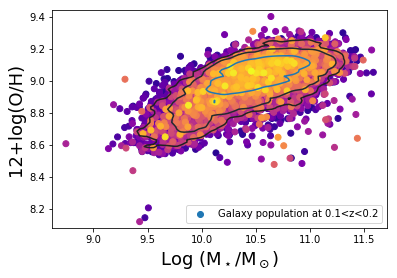

In [12]:
# Let's determine and plot the confidence regions where
# 68%, 95% and 99% of the galaxies at 0.1<z<0.2 lie.
levels = conflevels(logMstar_loz,Z_loz,nbins=100)

pylab.xlabel(r'Log (M$_\star$/M$_\odot$)',fontsize=18)
pylab.ylabel(r'12+log(O/H)',fontsize=18)
pylab.scatter(logMstar_loz, Z_loz, c=dencol_loz,cmap=cm.plasma,label='Galaxy population at 0.1<z<0.2')
sns.kdeplot(logMstar_loz,Z_loz,n_levels=levels)
pylab.legend(loc=4)

Data points that lie within these contours lie within 1, 2 and 3 sigma of the general population of star forming galaxies shown above. This is the 2-d equivalent of considering where a given measured parameter lies within the gaussian distribution of a larger sample of measurements.

This information can now be used to define outliers - these are data points that lie outside of the 99% confidence contours shown above.

## The mass-metallicity relation of gamma-ray burst (GRB) host galaxies; a comparison sample
Long Gamma ray bursts (GRBs) are a form of very energetic supernovae. They are incredibly luminous, and since they are associated with star formation, they are often used to study the properties of very distant galaxies.

Let's investigate how the GRB host galaxy mass-metallicity relation compares to that of the sample of the general galaxy polulation studied above.

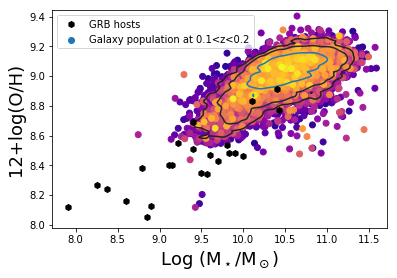

In [13]:
# Load in module needed to read in ascii files
import pandas as pd

# Let's first read in the GRB host galaxy data
df = pd.read_csv('Data/GRBhosts.dat',sep='\t')
GRBz = df['z'].values
GRBhost_Mstar = df['Mstar'].values
GRBhost_Z = df['12+log(O/H)'].values

#Plot GRB host galaxy metallicity against host galaxy stellar mass
pylab.xlabel(r'Log (M$_\star$/M$_\odot$)',fontsize=18)
pylab.ylabel(r'12+log(O/H)',fontsize=18)
pylab.scatter(logMstar_loz, Z_loz, c=dencol_loz,cmap=cm.plasma,label='Galaxy population at 0.1<z<0.2')
sns.kdeplot(logMstar_loz,Z_loz,n_levels=levels)
pylab.plot(GRBhost_Mstar,GRBhost_Z,'kh',label='GRB hosts')
pylab.legend(loc=2)

#### GRB host galaxies appears to occupy a different region of the parameter space compared to the general galaxy population.
Why might this be? [Tip: general population of galaxies is detected through stellar light, whereas GRBs are detected through their luminous aferglow]

### Different populations of galaxies and selection effects
It is important to investigate the apparent difference in the regions of the mass-metallicity relation occupied by galaxies selected in different ways using statistical methods. In this context, an important question to ask is whether the two galaxy samples are consistent or not with arising from the same parent population of star forming galaxies.

### The Kolmogorov-Smirnov test
One way of tackling this question is using the Kolmogorov–Smirnov (KS) test, which is a non-parametric test that measures the similarity between the cumulative probability distribution of a data sample and a reference probability distribution (one-sample KS test), or two data samples (two-sample K–S test). In our case, we want to apply the two-sample KS test to make a quantative statement on whether GRB host galaxies and the general sample of star-forming galaxies are consistent with being selected from the same parent population.

The KS statistic quantifies a distance between the cumulative distribution function of the two samples being compared. This is illustrated in the figure below, where the KS statitic, $D$, corresponds to the maxmum distance between the two cumulative probability distribution functions indicated by the black arrow.

<img src="KS2_Example.png" style="width: 300px;"/>
**Fig. 1.** *Illustration of the two-sample Kolmogorov–Smirnov statistic. Red and blue lines each correspond to an empirical distribution function, and the black arrow is the two-sample KS statistic (credit: Wikipedia)*.

The larger the value of $D$, the less likely that the two samples stem from the same parent population, and this is again quantified via the p-value. This is the probability of getting the difference $D$ given the null hypothesis that the two samples do not stem from the same parent population. Thus a small p-value indicates that the measured value of $D$ is very unlikely to arise given the null hypothesis, and thus the two samples are likely to originate from the same parent population.

### Do GRB host galaxies and general star-forming galaxy populations stem from the same parent population?
Let's test this out by applying the KS test to the observed mass distribution of GRB host galaxies with that expected if they follow the local mass-metallicity relation. 

In [14]:
# Load in module needed to apply 2-D KS test
from scipy.stats import ks_2samp

# Apply 2-D KS test to the stellar mass distribution of a sample of
# GRB host galaxies and a general population of star-forming galaxies
D, P = ks_2samp(GRBhost_Z,Z_loz)
print('\033[1m' + "The probability that D=%.2f given the null hypothesis is %.1f %% \n(i.e. the null hypothesis is rejected)" % (D,P*100) + '\033[0m')

The probability that D=0.90 given the null hypothesis is 0.0 % 
(i.e. the null hypothesis is rejected)


In [15]:
# Now lets compare the metallicity distributions
D, P = ks_2samp(GRBhost_Z,Z_loz)
print('\033[1m' + "\nThe probability that D=%.2f given the null hypothesis is %.1f %% \n(i.e. the null hypothesis is rejected)" % (D, P*100) + '\033[0m')


The probability that D=0.90 given the null hypothesis is 0.0 % 
(i.e. the null hypothesis is rejected)


### Let's consider how the GRB mass-metallicity relation evolves
The GRB host galaxy sample ranges from z=0.0085 to z=1.9223. We've seen some evidence of redshift evolution in the mass-metallicity relation of star-forming galaxies. Is this also seen in GRB host galaxies?

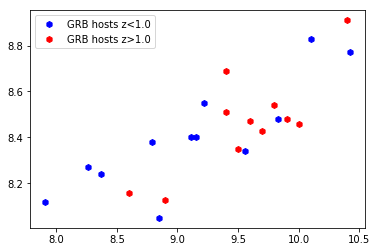

In [16]:
# Let's plot the distribution of GRB hosts at z<1.0 and at z<1.0
pylab.plot(GRBhost_Mstar[GRBz<1.0],GRBhost_Z[GRBz<1.0],'bh',label='GRB hosts z<1.0')
pylab.plot(GRBhost_Mstar[GRBz>1.0],GRBhost_Z[GRBz>1.0],'rh',label='GRB hosts z>1.0')
pylab.legend(loc=2)

### Your turn
Carry out a KS test to check whether the two GRB host galaxy populations at $z>1$ and $z<1$ originate from the same parent population

## Exoplanet properties and parameter dependencies
You should now be equipped with the statistical tools to compare your exoplanet with a larger sample of explanets, and thus place your exoplanet in the 'bigger context', and make some qualitative statements on the presence and significance of correlations and possible selection effecits. 

### Your turn
Given the parameters that you have measured for your exoplanet, what can you say about how it relates to the general population of exoplanets?

Quantify the significance of any correlation between orbital distance and planet mass for a large sample of explanets, and use this to assess how consistent your exoplanet is with other exoplanets.